This notebook produces photo-z estimations for 5927 objects from SDSS DR12, DR7, and GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits using the Nadaraya-Watson implementation from astroML, then compares those estimations to the spectroscopic redshift of those objects and the 4 photo-z estimation methods used by DES.  We also color the objects according to DES's object classification to show differences in performance between extended sources and point sources.  

3684 out of 693559 objects from GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits matched to DES SVA1 gold <br>
1974 out of 297301 quasars from SDSS DR12 matched to DES SVA1 gold <br>
269 out of 105783 quasars from SDSS DR7 matched to DES SVA1 gold <br>
5927 total objects 

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from astroML.linear_model import NadarayaWatson
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import palettable
import richardsplot as rplot
%matplotlib inline

In [2]:
#read in tables for sdss dr7, dr12, and gtr catalog
dr7_annz = Table.read('dr7Q+sva1gold_annz.fits')
dr12_annz = Table.read('dr12Q+sva1gold_annz.fits')
gtr_annz = Table.read('gtr_all+dessva1gold_annz.fits')
#prevent a bug involving MaskedColumns lacking a _mask attribute
gtr_annz = gtr_annz.filled()

In [3]:
dr7_bpz = Table.read('dr7Q+sva1gold_bpz.fits')
dr12_bpz = Table.read('dr12Q+sva1gold_bpz.fits')
gtr_bpz = Table.read('gtr_all+dessva1gold_bpz.fits')
gtr_bpz = gtr_bpz.filled()

In [4]:
dr7_skynet = Table.read('dr7Q+sva1gold_skynet.fits')
dr12_skynet = Table.read('dr12Q+sva1gold_skynet.fits')
gtr_skynet = Table.read('gtr_all+dessva1gold_skynet.fits')
gtr_skynet = gtr_skynet.filled()

In [5]:
dr7_tpz = Table.read('dr7Q+sva1gold_tpz.fits')
dr12_tpz = Table.read('dr12Q+sva1gold_tpz.fits')
gtr_tpz = Table.read('gtr_all+dessva1gold_tpz.fits')
gtr_tpz = gtr_tpz.filled()

In [6]:
#separate out photometry bands, des photometric redshift and des object classification
X1_annz = np.vstack([ dr7_annz['MAG_AUTO_G'], dr7_annz['MAG_AUTO_R'], dr7_annz['MAG_AUTO_I'], dr7_annz['MAG_AUTO_Z'], dr7_annz['Z_MEAN'], dr7_annz['MODEST_CLASS'] ]).T
X2_annz = np.vstack([ dr12_annz['MAG_AUTO_G'], dr12_annz['MAG_AUTO_R'], dr12_annz['MAG_AUTO_I'], dr12_annz['MAG_AUTO_Z'], dr12_annz['Z_MEAN'], dr12_annz['MODEST_CLASS'] ]).T
X3_annz = np.vstack([ gtr_annz['MAG_AUTO_G'], gtr_annz['MAG_AUTO_R'], gtr_annz['MAG_AUTO_I'], gtr_annz['MAG_AUTO_Z'], gtr_annz['Z_MEAN'], gtr_annz['MODEST_CLASS'] ]).T
#stack x's together for train_test_split
X_annz = np.concatenate((X1_annz, X2_annz))
X_annz = np.concatenate((X_annz, X3_annz))
#separate out spectroscopic redshifts
y1_annz = np.array(dr7_annz['z'])
y2_annz = np.array(dr12_annz['Z_PIPE'])
y3_annz = np.array(gtr_annz['zspec'])
#stack y's together for train_test_split
y_annz = np.concatenate((y1_annz, y2_annz))
y_annz = np.concatenate((y_annz, y3_annz))
#separate into training and test sets with test size of 1/5 of the objects
X_train_annz, X_test_annz, y_train_annz, y_test_annz = train_test_split(X_annz, y_annz, test_size=0.2, random_state = 64)
#prepare empty arrays for photometry bands
X_traintrue_annz = np.empty((X_train_annz.shape[0], X_train_annz.shape[1]-2), dtype=float) 
X_testtrue_annz = np.empty((X_test_annz.shape[0], X_test_annz.shape[1]-2), dtype=float)
#empty arrays for des photo-z and des object class
DesZs_annz = np.empty((X_test_annz.shape[0], 1), dtype=float) 
ModestClass_annz = np.empty((X_test_annz.shape[0], 1), dtype=int)
#separate photometry from des photo-z and object class
for i in range(len(X_train_annz)):
    X_traintrue_annz[i] = X_train_annz[i][:4] 
for i in range(len(X_test_annz)):
    X_testtrue_annz[i] = X_test_annz[i][:4] 
    DesZs_annz[i] = X_test_annz[i][4] 
    ModestClass_annz[i] = X_test_annz[i][5] 
#initialize Nadaraya Watson with a gaussian kernel of width 0.05
model_annz = NadarayaWatson('gaussian', 0.05) 
#fit the model to our training set
model_annz.fit(X_traintrue_annz, y_train_annz)
#predict redshifts for our test set
pred_annz = model_annz.predict(X_testtrue_annz)

c:\python27\lib\site-packages\astroML\linear_model\kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


In [7]:
X1_bpz = np.vstack([ dr7_bpz['MAG_AUTO_G'], dr7_bpz['MAG_AUTO_R'], dr7_bpz['MAG_AUTO_I'], dr7_bpz['MAG_AUTO_Z'], dr7_bpz['Z_MEAN'], dr7_bpz['MODEST_CLASS'] ]).T
X2_bpz = np.vstack([ dr12_bpz['MAG_AUTO_G'], dr12_bpz['MAG_AUTO_R'], dr12_bpz['MAG_AUTO_I'], dr12_bpz['MAG_AUTO_Z'], dr12_bpz['Z_MEAN'], dr12_bpz['MODEST_CLASS'] ]).T
X3_bpz = np.vstack([ gtr_bpz['MAG_AUTO_G'], gtr_bpz['MAG_AUTO_R'], gtr_bpz['MAG_AUTO_I'], gtr_bpz['MAG_AUTO_Z'], gtr_bpz['Z_MEAN'], gtr_bpz['MODEST_CLASS'] ]).T
X_bpz = np.concatenate((X1_bpz, X2_bpz))
X_bpz = np.concatenate((X_bpz, X3_bpz))
y1_bpz = np.array(dr7_bpz['z'])
y2_bpz = np.array(dr12_bpz['Z_PIPE'])
y3_bpz = np.array(gtr_bpz['zspec'])
y_bpz = np.concatenate((y1_bpz, y2_bpz))
y_bpz = np.concatenate((y_bpz, y3_bpz))

X_train_bpz, X_test_bpz, y_train_bpz, y_test_bpz = train_test_split(X_bpz, y_bpz, test_size=0.2, random_state = 64)

X_traintrue_bpz = np.empty((X_train_bpz.shape[0], X_train_bpz.shape[1]-2), dtype=float) 
X_testtrue_bpz = np.empty((X_test_bpz.shape[0], X_test_bpz.shape[1]-2), dtype=float)

DesZs_bpz = np.empty((X_test_bpz.shape[0], 1), dtype=float) 
ModestClass_bpz = np.empty((X_test_bpz.shape[0], 1), dtype=int)

for i in range(len(X_train_bpz)):
    X_traintrue_bpz[i] = X_train_bpz[i][:4] 
for i in range(len(X_test_bpz)):
    X_testtrue_bpz[i] = X_test_bpz[i][:4] 
    DesZs_bpz[i] = X_test_bpz[i][4] 
    ModestClass_bpz[i] = X_test_bpz[i][5] 

model_bpz = NadarayaWatson('gaussian', 0.05) 
model_bpz.fit(X_traintrue_bpz, y_train_bpz)
pred_bpz = model_bpz.predict(X_testtrue_bpz)

In [8]:
X1_skynet = np.vstack([ dr7_skynet['MAG_AUTO_G'], dr7_skynet['MAG_AUTO_R'], dr7_skynet['MAG_AUTO_I'], dr7_skynet['MAG_AUTO_Z'], dr7_skynet['Z_MEAN'], dr7_skynet['MODEST_CLASS'] ]).T
X2_skynet = np.vstack([ dr12_skynet['MAG_AUTO_G'], dr12_skynet['MAG_AUTO_R'], dr12_skynet['MAG_AUTO_I'], dr12_skynet['MAG_AUTO_Z'], dr12_skynet['Z_MEAN'], dr12_skynet['MODEST_CLASS'] ]).T
X3_skynet = np.vstack([ gtr_skynet['MAG_AUTO_G'], gtr_skynet['MAG_AUTO_R'], gtr_skynet['MAG_AUTO_I'], gtr_skynet['MAG_AUTO_Z'], gtr_skynet['Z_MEAN'], gtr_skynet['MODEST_CLASS'] ]).T
X_skynet = np.concatenate((X1_skynet, X2_skynet))
X_skynet = np.concatenate((X_skynet, X3_skynet))
y1_skynet = np.array(dr7_skynet['z'])
y2_skynet = np.array(dr12_skynet['Z_PIPE'])
y3_skynet = np.array(gtr_skynet['zspec'])
y_skynet = np.concatenate((y1_skynet, y2_skynet))
y_skynet = np.concatenate((y_skynet, y3_skynet))

X_train_skynet, X_test_skynet, y_train_skynet, y_test_skynet = train_test_split(X_skynet, y_skynet, test_size=0.2, random_state = 64)

X_traintrue_skynet = np.empty((X_train_skynet.shape[0], X_train_skynet.shape[1]-2), dtype=float) 
X_testtrue_skynet = np.empty((X_test_skynet.shape[0], X_test_skynet.shape[1]-2), dtype=float)

DesZs_skynet = np.empty((X_test_skynet.shape[0], 1), dtype=float) 
ModestClass_skynet = np.empty((X_test_skynet.shape[0], 1), dtype=int)

for i in range(len(X_train_skynet)):
    X_traintrue_skynet[i] = X_train_skynet[i][:4] 
for i in range(len(X_test_skynet)):
    X_testtrue_skynet[i] = X_test_skynet[i][:4] 
    DesZs_skynet[i] = X_test_skynet[i][4] 
    ModestClass_skynet[i] = X_test_skynet[i][5] 

model_skynet = NadarayaWatson('gaussian', 0.05) 
model_skynet.fit(X_traintrue_skynet, y_train_skynet)
pred_skynet = model_skynet.predict(X_testtrue_skynet)

In [9]:
X1_tpz = np.vstack([ dr7_tpz['MAG_AUTO_G'], dr7_tpz['MAG_AUTO_R'], dr7_tpz['MAG_AUTO_I'], dr7_tpz['MAG_AUTO_Z'], dr7_tpz['Z_MEAN'], dr7_tpz['MODEST_CLASS'] ]).T
X2_tpz = np.vstack([ dr12_tpz['MAG_AUTO_G'], dr12_tpz['MAG_AUTO_R'], dr12_tpz['MAG_AUTO_I'], dr12_tpz['MAG_AUTO_Z'], dr12_tpz['Z_MEAN'], dr12_tpz['MODEST_CLASS'] ]).T
X3_tpz = np.vstack([ gtr_tpz['MAG_AUTO_G'], gtr_tpz['MAG_AUTO_R'], gtr_tpz['MAG_AUTO_I'], gtr_tpz['MAG_AUTO_Z'], gtr_tpz['Z_MEAN'], gtr_tpz['MODEST_CLASS'] ]).T
X_tpz = np.concatenate((X1_tpz, X2_tpz))
X_tpz = np.concatenate((X_tpz, X3_tpz))
y1_tpz = np.array(dr7_tpz['z'])
y2_tpz = np.array(dr12_tpz['Z_PIPE'])
y3_tpz = np.array(gtr_tpz['zspec'])
y_tpz = np.concatenate((y1_tpz, y2_tpz))
y_tpz = np.concatenate((y_tpz, y3_tpz))

X_train_tpz, X_test_tpz, y_train_tpz, y_test_tpz = train_test_split(X_tpz, y_tpz, test_size=0.2, random_state = 64)

X_traintrue_tpz = np.empty((X_train_tpz.shape[0], X_train_tpz.shape[1]-2), dtype=float) 
X_testtrue_tpz = np.empty((X_test_tpz.shape[0], X_test_tpz.shape[1]-2), dtype=float)

DesZs_tpz = np.empty((X_test_tpz.shape[0], 1), dtype=float) 
ModestClass_tpz = np.empty((X_test_tpz.shape[0], 1), dtype=int)

for i in range(len(X_train_tpz)):
    X_traintrue_tpz[i] = X_train_tpz[i][:4] 
for i in range(len(X_test_tpz)):
    X_testtrue_tpz[i] = X_test_tpz[i][:4] 
    DesZs_tpz[i] = X_test_tpz[i][4] 
    ModestClass_tpz[i] = X_test_tpz[i][5] 

model_tpz = NadarayaWatson('gaussian', 0.05) 
model_tpz.fit(X_traintrue_tpz, y_train_tpz)
pred_tpz = model_tpz.predict(X_testtrue_tpz)

In [10]:
#ANNZ
#create some empty arrays to hold objects based on MODEST_CLASS from DES
stars_annz = np.empty(shape=(0,3))
gals_annz = np.empty(shape=(0,3))
uns_annz = np.empty(shape=(0,3))
#Loop through object classifications and sort objects accordingly, grabbing the Nadaraya-Watson prediction, Des's photo-z
#and the sdss spec-z
for i in range(len(ModestClass_annz)):
    if ModestClass_annz[i] == 2:
        stars_annz = np.append(stars_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)
    elif ModestClass_annz[i] == 1:
        gals_annz = np.append(gals_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)
    else:
        uns_annz = np.append(uns_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)

In [11]:
#bpz
#create some empty arrays to hold objects based on MODEST_CLASS from DES
stars_bpz = np.empty(shape=(0,3))
gals_bpz = np.empty(shape=(0,3))
uns_bpz = np.empty(shape=(0,3))
#Loop through object classifications and sort objects accordingly, grabbing the Nadaraya-Watson prediction, Des's photo-z
#and the sdss spec-z
for i in range(len(ModestClass_bpz)):
    if ModestClass_bpz[i] == 2:
        stars_bpz = np.append(stars_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)
    elif ModestClass_bpz[i] == 1:
        gals_bpz = np.append(gals_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)
    else:
        uns_bpz = np.append(uns_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)

In [12]:
#skynet
#create some empty arrays to hold objects based on MODEST_CLASS from DES
stars_skynet = np.empty(shape=(0,3))
gals_skynet = np.empty(shape=(0,3))
uns_skynet = np.empty(shape=(0,3))
#Loop through object classifications and sort objects accordingly, grabbing the Nadaraya-Watson prediction, Des's photo-z
#and the sdss spec-z
for i in range(len(ModestClass_skynet)):
    if ModestClass_skynet[i] == 2:
        stars_skynet = np.append(stars_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)
    elif ModestClass_skynet[i] == 1:
        gals_skynet = np.append(gals_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)
    else:
        uns_skynet = np.append(uns_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)

In [13]:
#tpz
#create some empty arrays to hold objects based on MODEST_CLASS from DES
stars_tpz = np.empty(shape=(0,3))
gals_tpz = np.empty(shape=(0,3))
uns_tpz = np.empty(shape=(0,3))
#Loop through object classifications and sort objects accordingly, grabbing the Nadaraya-Watson prediction, Des's photo-z
#and the sdss spec-z
for i in range(len(ModestClass_tpz)):
    if ModestClass_tpz[i] == 2:
        stars_tpz = np.append(stars_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)
    elif ModestClass_tpz[i] == 1:
        gals_tpz = np.append(gals_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)
    else:
        uns_tpz = np.append(uns_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)

c:\python27\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


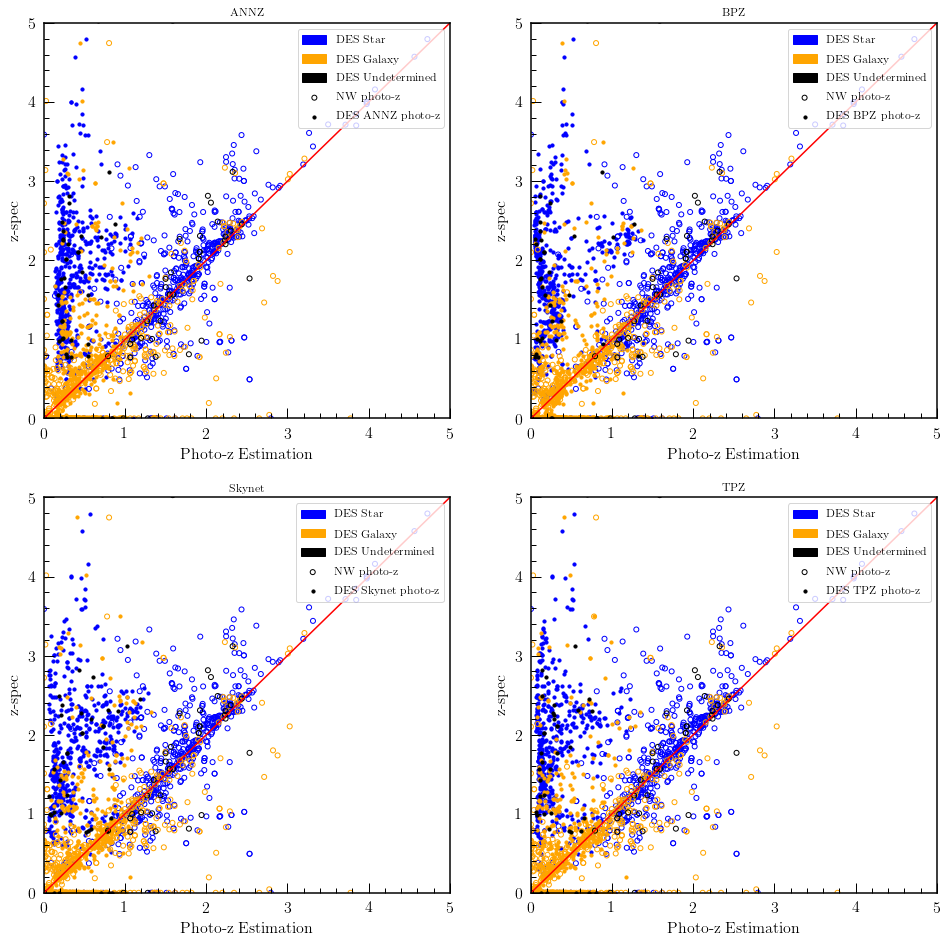

In [14]:
#plotting with MODEST_CLASS
plt.figure(figsize=(16,16))
plt.subplot(221)
#note that stars_annz.T[0] is our photo-z prediction, stars_annz.T[1] is the DES prediction, and stars_annz.T[2] is the zspec
plt.scatter(stars_annz.T[0], stars_annz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_annz.T[1], stars_annz.T[2], s=10, c='blue')
#same for gals_annz and uns_annz
plt.scatter(gals_annz.T[0], gals_annz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_annz.T[1], gals_annz.T[2], s=10, c='orange')
#black points (undetermined objects) carry the legend tags for open circles and closed points
legendhelp1_annz = plt.scatter(uns_annz.T[0], uns_annz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_annz = plt.scatter(uns_annz.T[1], uns_annz.T[2], s=10, c='k', label = 'DES ANNZ photo-z')
plt.plot([0,1,2,3,4,5], 'r') #plot a one-to-one line for reference
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('z-spec')
plt.title('ANNZ')
#colored patches for the legend
orange_patch = mpatches.Patch(color='orange', label='DES Galaxy')
blue_patch = mpatches.Patch(color='blue', label='DES Star')
black_patch = mpatches.Patch(color='k', label='DES Undetermined')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_annz, legendhelp2_annz], loc=1)
plt.subplot(222)
plt.scatter(stars_bpz.T[0], stars_bpz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_bpz.T[1], stars_bpz.T[2], s=10, c='blue')
plt.scatter(gals_bpz.T[0], gals_bpz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_bpz.T[1], gals_bpz.T[2], s=10, c='orange')
legendhelp1_bpz = plt.scatter(uns_bpz.T[0], uns_bpz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_bpz = plt.scatter(uns_bpz.T[1], uns_bpz.T[2], s=10, c='k', label = 'DES BPZ photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('z-spec')
plt.title('BPZ')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_bpz, legendhelp2_bpz], loc=1)
plt.subplot(223)
plt.scatter(stars_skynet.T[0], stars_skynet.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_skynet.T[1], stars_skynet.T[2], s=10, c='blue')
plt.scatter(gals_skynet.T[0], gals_skynet.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_skynet.T[1], gals_skynet.T[2], s=10, c='orange')
legendhelp1_skynet = plt.scatter(uns_skynet.T[0], uns_skynet.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_skynet = plt.scatter(uns_skynet.T[1], uns_skynet.T[2], s=10, c='k', label = 'DES Skynet photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('z-spec')
plt.title('Skynet')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_skynet, legendhelp2_skynet], loc=1)
plt.subplot(224)
plt.scatter(stars_tpz.T[0], stars_tpz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_tpz.T[1], stars_tpz.T[2], s=10, c='blue')
plt.scatter(gals_tpz.T[0], gals_tpz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_tpz.T[1], gals_tpz.T[2], s=10, c='orange')
legendhelp1_tpz = plt.scatter(uns_tpz.T[0], uns_tpz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_tpz = plt.scatter(uns_tpz.T[1], uns_tpz.T[2], s=10, c='k', label = 'DES TPZ photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('z-spec')
plt.title('TPZ')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_tpz, legendhelp2_tpz], loc=1)

Above plots show each of the 4 DES photo-z methods and our Nadaraya-Watson estimation against the spectroscopic redshift of the objects.  Open circles represent our NW estimations and closed dots represent the respective DES estimation.  Points are colored based on DES's object classification method: MODEST_CLASS, which sorts objects into galaxies, stars, and undetermined objects